# Tracking Depression and Suicidal Ideation in Social Media
### Analysis and Dashboarding for tracking features associated with mental health risk
## Part 1 - Hypothesis Confirmation

### Table of Contents

* <a href='#Part_1'> Abstract</a> 
* <a href='#Part_2'> Obtain & Scrub</a>   
* <a href='#Part_3'> Data Exploration</a> 
* <a href='#Part_4'> Hypothesis Testing</a>
* <a href='#Part_5'> Conclusions</a>

In [1]:
#Importing Libraries
import requests
import nltk
import json
import time
import pandas as pd
import numpy as np
import re
import pymongo
import praw
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels
import functions as functions

from math import sqrt
from numpy import mean, var
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
from scipy import stats
from importlib import reload
from os import path
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pymongo import errors, MongoClient
from pymongo.errors import InvalidDocument
from statsmodels.stats import power

from functions import connect_to_reddit, connect_to_mongo, get_stem_abs, get_stop_words, text_cleaner, get_date 
from functions import submissions_to_mongo, clean_df, get_tot_word, get_abs_word_count, get_perc_abs, cohend, mongo_to_df
from functions import get_abs_chart, get_post_distribution, wordcloud, clean_text, get_distribution, get_word_freq


reddit connector created
pillosoft connecting to reddit API
mongo connector now created
get stem abs list function created
get lem abs list function created
get stop words function has been created
text cleaner function created
get date function created
submissions to mongo function created
clean df function created
get total word count function created
get absolutist word count created
get percentage of absolutist words function created
get absolitist word count chart function created
get post distribution function created
get word cloud function created
get clean text function created
get perc distribution created
get word frequency function created
Cohens D function created
mongo to df function created
plot confusion matrix function created
evaluate model function created
get authors function created
get author posts function created
check exists function created
date function created


<a id='Part_1'></a>

# Abstract

In psychology and cognitive therapy, it is widely understood that absolutist thinking is a problem that must be addressed with mental health patients, specifically among those who are diagnosed with depression, anxiety and suicidal ideation. A recent 
<a href="https://journals.sagepub.com/doi/full/10.1177/2167702617747074">Article</a>
found an that increased use of absolutist words in social media was highly correlated with depressed, anxious, and suicidal forums. 
Specific words, such as; "everything", "nothing", "always", "all", and "everyone", to name a few, were identified as being used significantly more in depression, anxiety, and suicide related forums when compared to other clinical and non-clinical forums. Suicide-related forums were also found to have a statistically significant increased usage of these words compared to depression and anxiety related forums. The 2018 study, which was done in the United Kingdom, analyzed <a href="https://journals.sagepub.com/doi/suppl/10.1177/2167702617747074/suppl_file/Table_S1_Supplemental_Material.pdf">British forums</a> for data analysis. Here, I attempt to use similar methods to validate thier conclusions.

In [2]:
# connecting to mongo database
client = connect_to_mongo()
# connecting to reddit api
reddit = connect_to_reddit()


now connected to mongo
pillosoft connecting to reddit API


In [3]:
#creating a new collection in our database
reddit_db = client["reddit"]
reddit_submissions = reddit_db["reddit_submissions_for_hypothesis_testing"]

#list of subreddit names we will be analyzing
subreddit_list = ['suicidewatch', 'depression', 'anxiety',
                  'diabetes', 'heartdisease', 'gout', 'copd',
                  'travel', 'basketball', 'harrypotter']
#creating a list of moderators for each subreddit so that we do not include their posts in the analysis
moderators = ['S2S2S2S2S2','Psy-Kosh','SicSemperHumanus','SQLwitch','UnDire','pkbooo','skyqween','MykeeB',
              'circinia','svneko','MuffinMedic','remyschnitzel','vodkalimes','dwade333miami','anxietymods',
              'BotBust','MrZalarox','Pi25','analemmaro','abhava-sunya','sofar1776','AccioInternets','palisade2621',
              'Hermiones_Teaspoon','AweBeyCon','dancingonfire','midnightdragon','elbowsss','Chefjones','pezes',
              'sulkee','Greypo','exoendo','Jakeable','MeghanAM','JoyousCacophony','hansjens47','Qu1nlan',
              'english06','samplebitch','optimalg','rhiever','Geographist','frostickle','NonNonHeinous',
              'Vizual-Statistix','sarahbotts','zonination','spermface','yelper','mungoflago','ostedog','rsrsrsrs',
              'townie_immigrant','JoeAllan','theReluctantHipster','AutoModerator', 'iimsorryy','wanderlusterer',
              'awaxa','dosman711','mmccullen','Ariensus','turtletechnology','cascer1','cluckj','adidushi',
              'Muffinzz','IHaveTheBestCandy','crilen','Cerenkov_Blue', 'binarysneaker','vomita_conejitos','polezo']


In [4]:

#absolutist words we will be examining for hypothesis testing
abs_word_list = ['absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly', 'definitely', 
                 'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                 'totally', 'whole']
#stemming absolutist words before analysis
stem = PorterStemmer()
stem_abs = get_stem_abs(abs_word_list)

#stop words to use for analysis
pre_stop_words = list(stopwords.words("english"))
#remove these irrelevant words by including them in stop words dictionary
remove_words = ["http", "https", "www", "com", "reddit", "jpg", 'x', 'b', 'f', 'r', 'c', 'd', 'e', 'f', 
               'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'op', 'q', 's', 't', 'u', 'v', 'w', 'y', 'z',
               '00', '01', '04', '10', '100', '1000', '1000mg', '100mg', '100x', '108', '10k', '10lbs', 
                '10pm', '10th', '10yo', '10yrs', '11', '119', '11am', '11d', '11th', '12', '120', '12g', 
                '12ga', '12ish', '13', '14', '140', '146', '15', '150', '150mg', '1549449839413', '15min', 
                '16', '160', '162', '16f', '16y', '17', '170', '17f', '17th', '17yo', '18', '180', '189', 
                '18months', '18th', '19', '1950', '1974', '1996', '19o', '19th', '1drl', '1k', '1mg', '1st', 
                '1x', '20', '200', '2000', '2003', '2007', '200mg', '2010', '2012', '2014', '2015', '2016', 
                '2017', '2018', '2019', '20mg', '20oz', '20th', '21', '215lbs', '22', '22m', '23', '2300', 
                '23andme', '24', '24hrs', '25', '250', '2500', '250mg', '258', '25mg', '25th', '26', '260lbs', 
                '26yo', '27', '270', '27th', '27year', '28', '28th', '29', '2ahukewiuracn9kbgahvb6kqkhy2ld', 
                '2am', '2l', '2lbs', '2mo', '2nd', '2wks', '2x', '2years', '2yrs', '30', '300', '3000', 
                '3000mg', '300mg', '304', '30th', '31', '310', '31st', '32', '325mg', '32oz', '33', '34', 
                '340', '35', '350', '357', '37', '38', '39', '3am', '3lb', '3mg', '3pm', '3rd', '3rds', '40', 
                '400', '40cl', '40km', '40lbs', '40mg', '40s', '40th', '42', '43m', '44', '45', '450', '48', 
                '48oz', '49', '4am', '4th', '50', '500', '500mg', '50mcg', '50mg', '50oz', '50s', '5150', '5600',
                '5677676', '57', '5k', '5mg', '5pm', '5th', '60', '600', '600mg', '60k', '61', '63', '64', '6am',
                '6mg', '6th', '6yrs', '70', '700', '70cl', '70s', '72', '75mg', '79558b7f', '7pm', '7t4ngdpbitq',
                '7th', '80', '800', '8th', '90', '92', '95', '99', '9am', '9th', '___', '_a', '_anyone', '_be',
                '_food', '_for', '_in', '_interested', '_me', '_tracker', 'aa', 'aans']
#removing absolutist words from stop words list
stop_words = get_stop_words(remove_words, abs_word_list, pre_stop_words)

stop words list length is now:
179
adding words from include list
new words have been added, stop words list length is now:
428
removing exlude words
exclude list words removed. stop words length is now:
427


<a id='Part_2'></a>

# Obtain & Scrub

In [5]:
#creating a dataframe after querying reddit data using praw. Data will also be stored in a mongo db for future use.
submissions_to_mongo(subreddit_list, reddit_submissions, reddit, moderators, stop_words)
reddit_df = mongo_to_df(reddit_df, reddit_submissions)
reddit_df.drop_duplicates(subset='cleaned_text', inplace=True)


In [6]:
#generating a word corpus list for each submission in each subreddit for analysis
suicide_corpus = clean_df(reddit_df, subreddit='SuicideWatch', stop_words=stop_words)
depression_corpus = clean_df(reddit_df, subreddit='depression', stop_words=stop_words)
anxiety_corpus = clean_df(reddit_df, subreddit='Anxiety', stop_words=stop_words)

copd_corpus = clean_df(reddit_df, subreddit='COPD', stop_words=stop_words)
gout_corpus = clean_df(reddit_df, subreddit='gout', stop_words=stop_words)
diabetes_corpus = clean_df(reddit_df, subreddit='diabetes', stop_words=stop_words)
hypertension_corpus = clean_df(reddit_df, subreddit='HeartDisease', stop_words=stop_words)

harrypotter_corpus = clean_df(reddit_df, subreddit='harrypotter', stop_words=stop_words)
travel_corpus = clean_df(reddit_df, subreddit='travel', stop_words=stop_words)
basketball_corpus = clean_df(reddit_df, subreddit='Basketball', stop_words=stop_words)

In [7]:
corps = [suicide_corpus, depression_corpus, anxiety_corpus, diabetes_corpus, hypertension_corpus, gout_corpus, 
        copd_corpus, travel_corpus, basketball_corpus, harrypotter_corpus]

<a id='Part_3'></a>

# Data Exploration

In [8]:
#Creating a table that gives a snapshot analysis of the forums we are gathering data from
avg_length = []
for corp in corps:
    post_length = []
    for post in corp:
        num = len(post)
        post_length.append(num)
    post_length = np.array(post_length)
    avg_length.append(post_length.mean())

forum_characteristics = pd.DataFrame(columns=['Category','Forum','Source','Number_of_Posts',
                                              'Avg_Post_Word_Length','Total_Word_Count','Forum_Absolutist_Word_%'])

forum_characteristics.Forum = pd.Series(reddit_df.subreddit.unique())

forum_characteristics.Category = pd.Series(['Mental Health', 'Mental Health', 'Mental Health', 
                                            'Chronic Illness', 'Chronic Illness', 'Chronic Illness', 'Chronic Illness',
                                           'Non Clinical', 'Non Clinical', 'Non Clinical'])

forum_characteristics.Source = pd.Series(['reddit.com/r/SuicideWatch','reddit.com/r/depression', 
                                          'reddit.com/r/Anxiety','reddit.com/r/diabetes', 
                                          'reddit.com/r/HeartDisease','reddit.com/r/gout','reddit.com/r/COPD', 
                                          'reddit.com/r/travel','reddit.com/r/Basketball','reddit.com/r/harrypotter'])

forum_characteristics.Number_of_Posts = pd.Series(reddit_df.groupby('subreddit', sort=False).subreddit.value_counts().values)

forum_characteristics.Avg_Post_Word_Length = pd.Series(avg_length)

forum_characteristics.Total_Word_Count = pd.Series([len(' '.join(corp)) for corp in corps])

forum_characteristics['Forum_Absolutist_Word_%'] = pd.Series([get_perc_abs(corp, stem_abs=stem_abs) for corp in corps])
forum_characteristics

,Category,Forum,Source,Number_of_Posts,Avg_Post_Word_Length,Total_Word_Count,Forum_Absolutist_Word_%
0,Mental Health,SuicideWatch,reddit.com/r/SuicideWatch,935,558.106125,244653657,3.998514
1,Mental Health,depression,reddit.com/r/depression,962,473.496467,219788186,4.034568
2,Mental Health,Anxiety,reddit.com/r/Anxiety,959,520.175041,239907294,3.261417
3,Chronic Illness,diabetes,reddit.com/r/diabetes,659,377.569297,82327464,1.956184
4,Chronic Illness,HeartDisease,reddit.com/r/HeartDisease,163,522.586787,6998260,2.055606
5,Chronic Illness,gout,reddit.com/r/gout,891,417.219585,166194607,2.180488
6,Chronic Illness,COPD,reddit.com/r/COPD,139,462.685406,4511658,1.853321
7,Non Clinical,travel,reddit.com/r/travel,558,415.087150,64893367,1.738818
8,Non Clinical,Basketball,reddit.com/r/Basketball,636,230.346633,46862961,1.944061
9,Non Clinical,harrypotter,reddit.com/r/harrypotter,577,386.120148,64553445,2.436455


      Word cloud for Suicide Watch Forum:


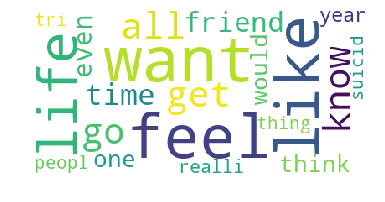




      Word cloud for Anxiety Forum:


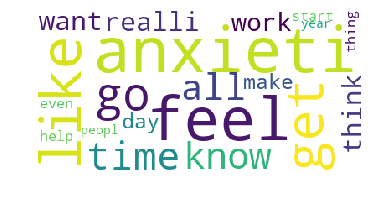




      Word cloud for Depression Forum:


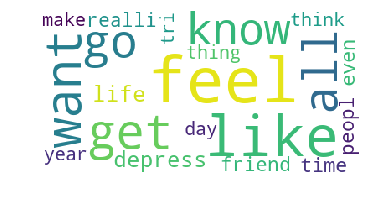




      Word cloud for COPD Forum:


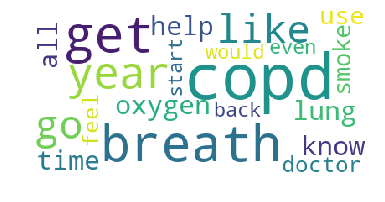




      Word cloud for Heart Disease Forum:


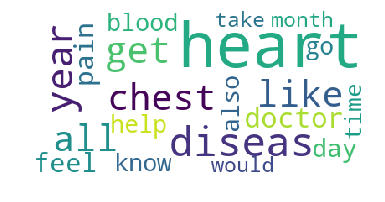




      Word cloud for Gout Forum:


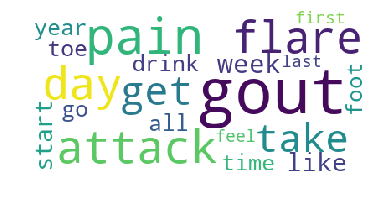




      Word cloud for Diabetes Forum:


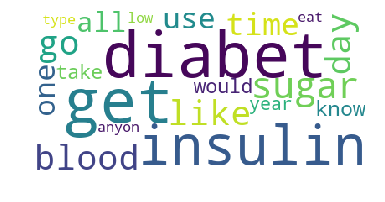




      Word cloud for Harry Potter Forum:


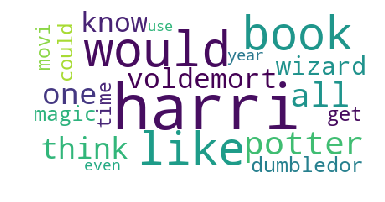




      Word cloud for Travel Forum:


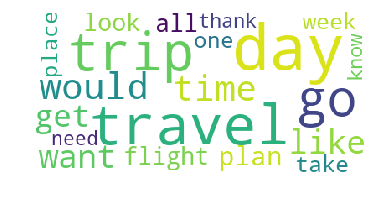




      Word cloud for Basketball Forum:


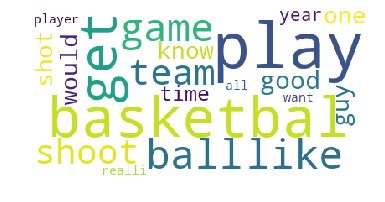

In [9]:
# Generating Word Clouds
print('      Word cloud for Suicide Watch Forum:')
wordcloud(' '.join(suicide_corpus), stop_words)
print('\n\n')
print('      Word cloud for Anxiety Forum:')
wordcloud(' '.join(anxiety_corpus), stop_words)
print('\n\n')
print('      Word cloud for Depression Forum:')
wordcloud(' '.join(depression_corpus), stop_words)
print('\n\n')
print('      Word cloud for COPD Forum:')
wordcloud(' '.join(copd_corpus), stop_words)
print('\n\n')
print('      Word cloud for Heart Disease Forum:')
wordcloud(' '.join(hypertension_corpus), stop_words)
print('\n\n')
print('      Word cloud for Gout Forum:')
wordcloud(' '.join(gout_corpus), stop_words)
print('\n\n')
print('      Word cloud for Diabetes Forum:')
wordcloud(' '.join(diabetes_corpus), stop_words)
print('\n\n')
print('      Word cloud for Harry Potter Forum:')
wordcloud(' '.join(harrypotter_corpus), stop_words)
print('\n\n')
print('      Word cloud for Travel Forum:')
wordcloud(' '.join(travel_corpus), stop_words)
print('\n\n')
print('      Word cloud for Basketball Forum:')
wordcloud(' '.join(basketball_corpus), stop_words)

Absolutist Word Count for Suicide Watch Forum


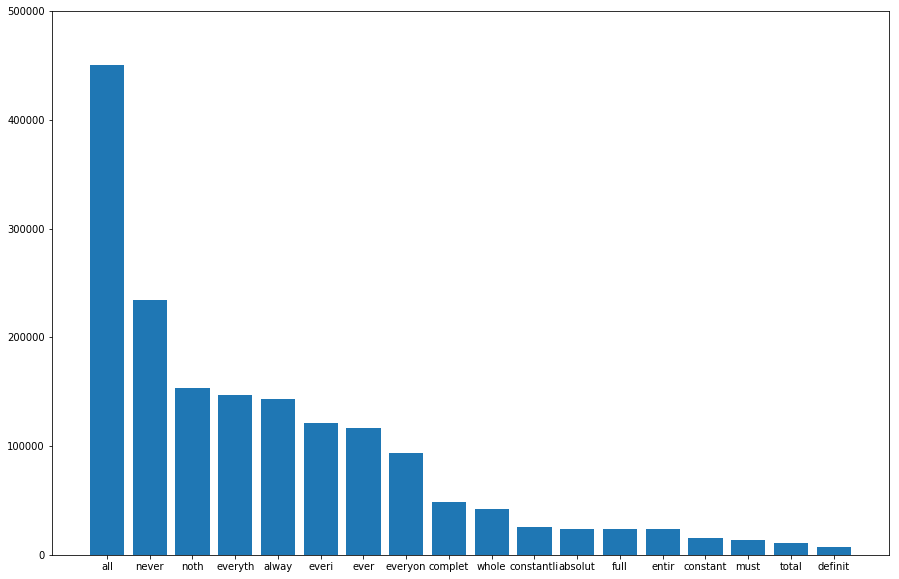

Absolutist Word Count for Gout Forum


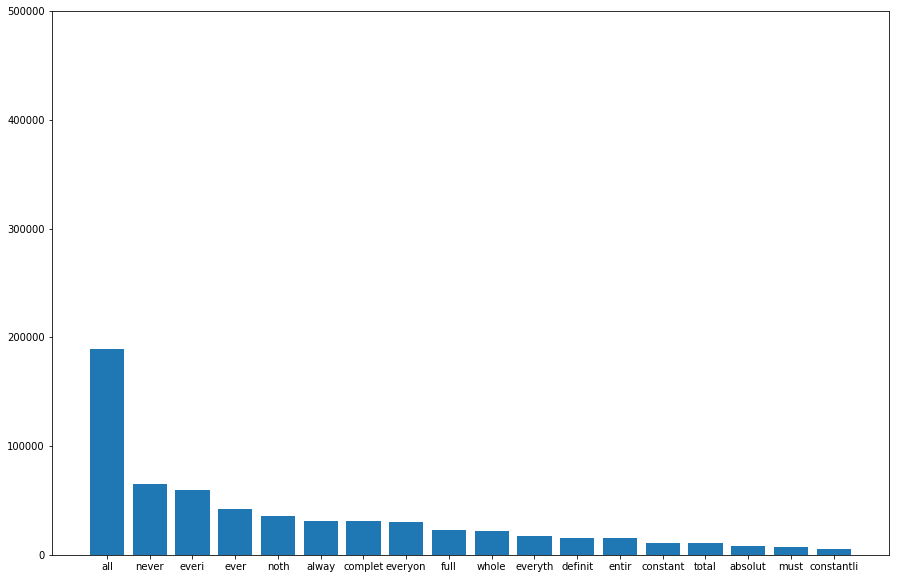

Absolutist Word Count for Travel Forum


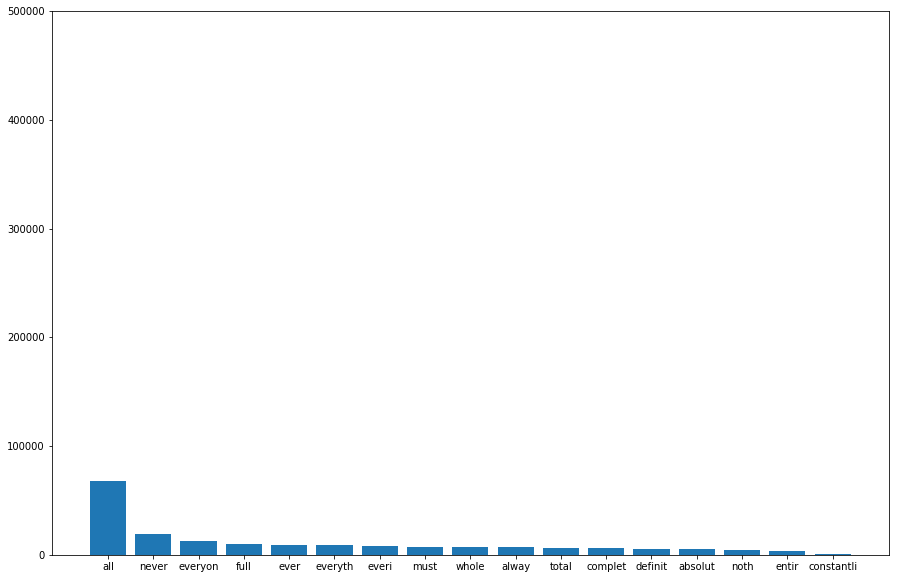

In [10]:
#Generating a barchart that counts the frequency of absolutist words used in the forum
print('Absolutist Word Count for Suicide Watch Forum')
get_abs_chart(suicide_corpus, stem_abs=stem_abs)
print('Absolutist Word Count for Gout Forum')
get_abs_chart(gout_corpus, stem_abs=stem_abs)
print('Absolutist Word Count for Travel Forum')
get_abs_chart(travel_corpus, stem_abs=stem_abs)

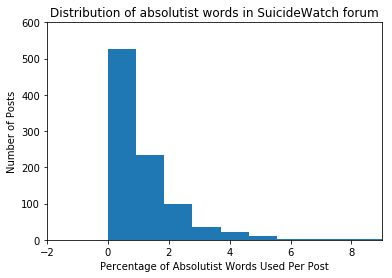

Total number of words analyzed in SuicideWatch forum: 42354257
Total number of absolutist words used in SuicideWatch forum: 1693541
Percentage of absolutist words in corpus: 3.9985142461594827


In [11]:
# Generating a percentage of absolutist words distribution for each forum
suicide_dist = get_post_distribution(reddit_df, subreddit='SuicideWatch', stem_abs=stem_abs)
print('Total number of words analyzed in SuicideWatch forum: {}'.format(get_tot_word(suicide_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in SuicideWatch forum: {}'.format(get_abs_word_count(suicide_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(suicide_corpus, stem_abs=stem_abs)))

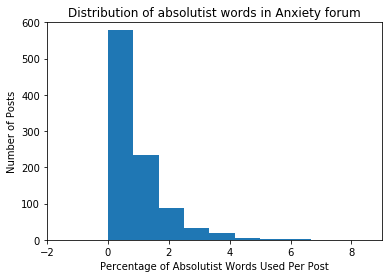

Total number of words analyzed in Anxiety forum: 40560494
Total number of absolutist words used in Anxiety forum: 1322847
Percentage of absolutist words in corpus: 3.2614173782005715


In [12]:
# Generating a percentage of absolutist words distribution for each forum
anxiety_dist = get_post_distribution(reddit_df, subreddit='Anxiety', stem_abs=stem_abs)
print('Total number of words analyzed in Anxiety forum: {}'.format(get_tot_word(anxiety_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in Anxiety forum: {}'.format(get_abs_word_count(anxiety_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(anxiety_corpus, stem_abs=stem_abs)))

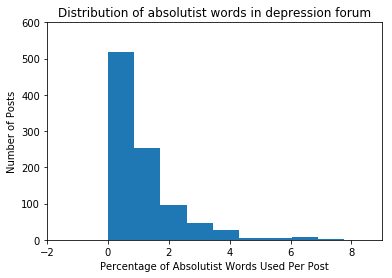

Total number of words analyzed in depression forum: 37770310
Total number of absolutist words used in depression forum: 1523869
Percentage of absolutist words in corpus: 4.03456842159887


In [13]:
# Generating a percentage of absolutist words distribution for each forum
depression_dist = get_post_distribution(reddit_df, subreddit='depression', stem_abs=stem_abs)
print('Total number of words analyzed in depression forum: {}'.format(get_tot_word(depression_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in depression forum: {}'.format(get_abs_word_count(depression_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(depression_corpus, stem_abs=stem_abs)))

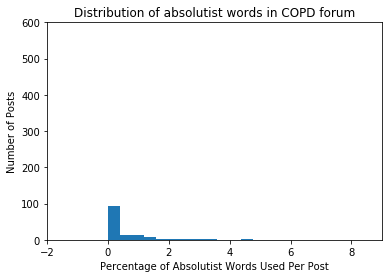

Total number of words analyzed in COPD forum: 748872
Total number of absolutist words used in COPD forum: 13879
Percentage of absolutist words in corpus: 1.8533207277078059


In [14]:
# Generating a percentage of absolutist words distribution for each forum
copd_dist = get_post_distribution(reddit_df, subreddit='COPD', stem_abs=stem_abs)
print('Total number of words analyzed in COPD forum: {}'.format(get_tot_word(copd_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in COPD forum: {}'.format(get_abs_word_count(copd_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(copd_corpus, stem_abs=stem_abs)))

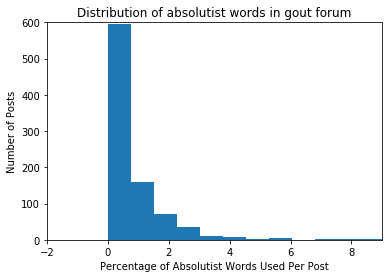

Total number of words analyzed in Gout forum: 28374340
Total number of absolutist words used in Gout forum: 618699
Percentage of absolutist words in corpus: 2.180487722357595


In [15]:
# Generating a percentage of absolutist words distribution for each forum
gout_dist = get_post_distribution(reddit_df, subreddit='gout', stem_abs=stem_abs)
print('Total number of words analyzed in Gout forum: {}'.format(get_tot_word(gout_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in Gout forum: {}'.format(get_abs_word_count(gout_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(gout_corpus, stem_abs=stem_abs)))

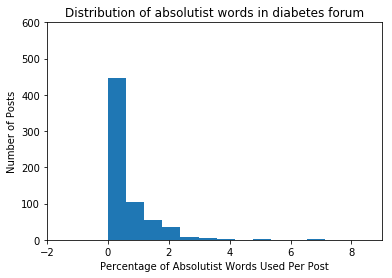

Total number of words analyzed in Diabetes forum: 13984878
Total number of absolutist words used in Diabetes forum: 273570
Percentage of absolutist words in corpus: 1.9561843871644786


In [16]:
# Generating a percentage of absolutist words distribution for each forum
diabetes_dist = get_post_distribution(reddit_df, subreddit='diabetes', stem_abs=stem_abs)
print('Total number of words analyzed in Diabetes forum: {}'.format(get_tot_word(diabetes_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in Diabetes forum: {}'.format(get_abs_word_count(diabetes_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(diabetes_corpus, stem_abs=stem_abs)))

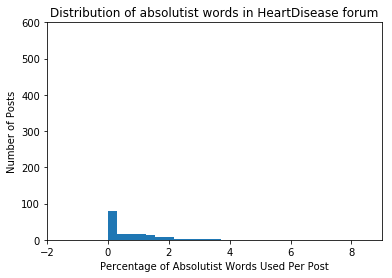

Total number of words analyzed in Hypertension forum: 1140491
Total number of absolutist words used in Hypertension forum: 23444
Percentage of absolutist words in corpus: 2.055605875013481


In [17]:
# Generating a percentage of absolutist words distribution for each forum
hypertension_dist = get_post_distribution(reddit_df, subreddit='HeartDisease', stem_abs=stem_abs)
print('Total number of words analyzed in Hypertension forum: {}'.format(get_tot_word(hypertension_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in Hypertension forum: {}'.format(get_abs_word_count(hypertension_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(hypertension_corpus, stem_abs=stem_abs)))

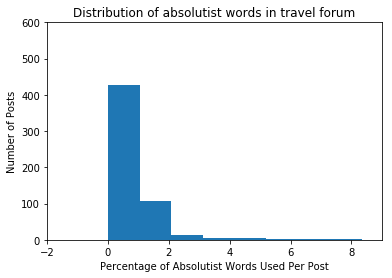

Total number of words analyzed in Travel forum: 10852834
Total number of absolutist words used in Travel forum: 188711
Percentage of absolutist words in corpus: 1.7388177134193705


In [18]:
# Generating a percentage of absolutist words distribution for each forum
travel_dist = get_post_distribution(reddit_df, subreddit='travel', stem_abs=stem_abs)
print('Total number of words analyzed in Travel forum: {}'.format(get_tot_word(travel_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in Travel forum: {}'.format(get_abs_word_count(travel_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(travel_corpus, stem_abs=stem_abs)))

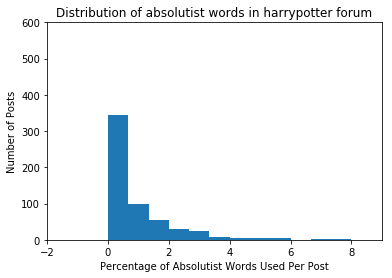

Total number of words analyzed in Harry Potter forum: 10490405
Total number of absolutist words used in Harry Potter forum: 255594
Percentage of absolutist words in corpus: 2.4364550272367937


In [19]:
# Generating a percentage of absolutist words distribution for each forum
harrypotter_dist = get_post_distribution(reddit_df, subreddit='harrypotter', stem_abs=stem_abs)
print('Total number of words analyzed in Harry Potter forum: {}'.format(get_tot_word(harrypotter_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in Harry Potter forum: {}'.format(get_abs_word_count(harrypotter_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(harrypotter_corpus, stem_abs=stem_abs)))

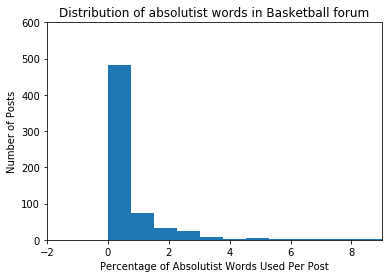

Total number of words analyzed in Basketball forum: 8029431
Total number of absolutist words used in Basketball forum: 156097
Percentage of absolutist words in corpus: 1.9440605442652164


In [20]:
# Generating a percentage of absolutist words distribution for each forum
basketball_dist = get_post_distribution(reddit_df, subreddit='Basketball', stem_abs=stem_abs)
print('Total number of words analyzed in Basketball forum: {}'.format(get_tot_word(basketball_corpus, stem_abs=stem_abs)))
print('Total number of absolutist words used in Basketball forum: {}'.format(get_abs_word_count(basketball_corpus, stem_abs=stem_abs)))
print('Percentage of absolutist words in corpus: {}'.format(get_perc_abs(basketball_corpus, stem_abs=stem_abs)))

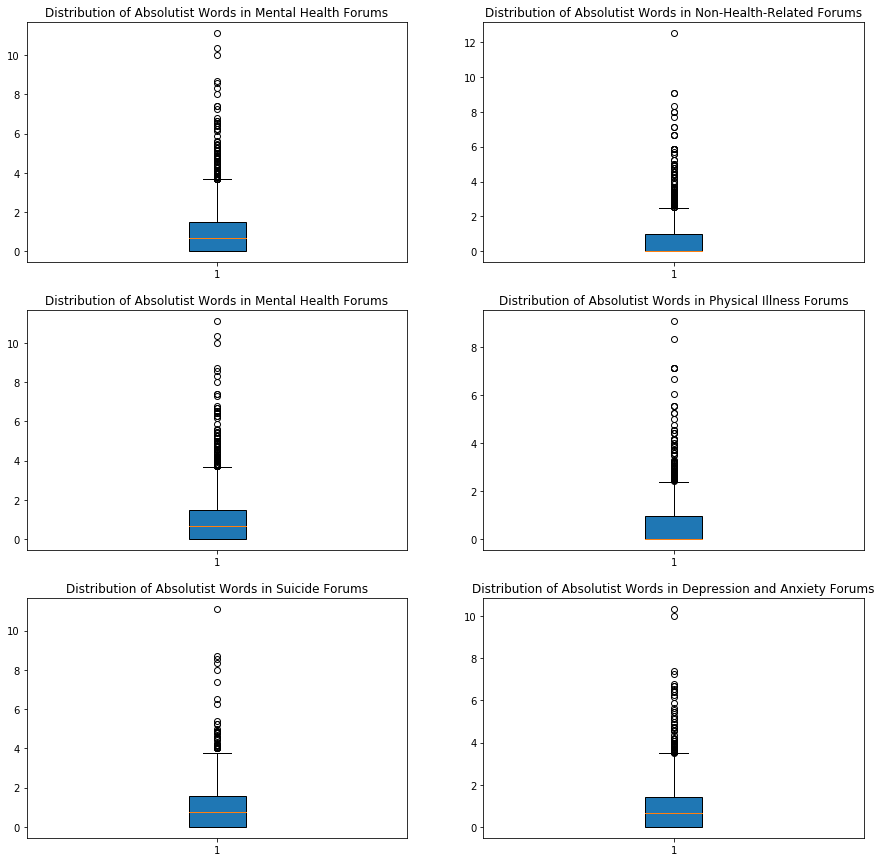

In [21]:
# Examining the distributions side by side using box whisker plots

mh_forums = suicide_dist + depression_dist + anxiety_dist

clinical_forums = hypertension_dist + gout_dist + diabetes_dist + copd_dist

misc_forums = harrypotter_dist + travel_dist + basketball_dist

suicide_forums = suicide_dist

depanx_forums = depression_dist + anxiety_dist

fig, ax = plt.subplots(3,2,figsize=(15,15))
ax[0,0].boxplot(mh_forums, meanline=True, patch_artist=True)
ax[0,0].set_title('Distribution of Absolutist Words in Mental Health Forums')
ax[0,1].boxplot(misc_forums, meanline=True, patch_artist=True)
ax[0,1].set_title('Distribution of Absolutist Words in Non-Health-Related Forums')
ax[1,0].boxplot(mh_forums, meanline=True, patch_artist=True)
ax[1,0].set_title('Distribution of Absolutist Words in Mental Health Forums')
ax[1,1].boxplot(clinical_forums, meanline=True, patch_artist=True)
ax[1,1].set_title('Distribution of Absolutist Words in Physical Illness Forums')
ax[2,0].boxplot(suicide_forums, meanline=True, patch_artist=True)
ax[2,0].set_title('Distribution of Absolutist Words in Suicide Forums')
ax[2,1].boxplot(depanx_forums, meanline=True, patch_artist=True)
ax[2,1].set_title('Distribution of Absolutist Words in Depression and Anxiety Forums');

<a id='Part_4'></a>

# Hypothesis Testing

In [22]:
#converting data to numpy arrays
mh_array = np.asarray(mh_forums)
misc_array = np.asarray(misc_forums)
clinical_array = np.asarray(clinical_forums)
sui_array = np.asarray(suicide_forums)
depanx_array = np.asarray(depanx_forums)

In [23]:
#exploring forum statistics
print('mental health forums mean, standard deviation, and variance:      ', 
      round(mh_array.mean(),2),', ', round(mh_array.std(),2),', ', round(mh_array.var(),2))
print('non-health related forums mean, standard deviation, and variance: ', 
      round(misc_array.mean(),2),', ', round(misc_array.std(),2),', ', round(misc_array.var(),2))
print('physical illness forums mean, standard deviation, and variance:   ', 
      round(clinical_array.mean(),2),', ', round(clinical_array.std(),2),', ', round(clinical_array.var(),2))
print('suicide forums mean, standard deviation, and variance:            ', 
      round(sui_array.mean(),2),', ', round(sui_array.std(),2),', ', round(sui_array.var(),2))
print('depression/anxiety forums mean, standard deviation, and variance: ', 
      round(depanx_array.mean(),2),', ', round(depanx_array.std(),2),', ', round(depanx_array.var(),2))

mental health forums mean, standard deviation, and variance:       0.96 ,  1.19 ,  1.41
non-health related forums mean, standard deviation, and variance:  0.65 ,  1.17 ,  1.37
physical illness forums mean, standard deviation, and variance:    0.61 ,  0.98 ,  0.96
suicide forums mean, standard deviation, and variance:             1.04 ,  1.28 ,  1.64
depression/anxiety forums mean, standard deviation, and variance:  0.92 ,  1.14 ,  1.29


# Do mental health forums have more absolutist words per post than hobby-type forums?
## The Alternative and Null Hypothesis:

### 𝐻a: μ1 > μ2
The average percentage of absolitist words is higher in mental health forums than the average percentage of absolutist words in hobby forums 

### 𝐻o: μ1 <= μ2
The average percentage of absolitist words in mental health forums is the same or less than the average percentage of absolutist words in hobby forums 

In [24]:
#Two Sample T-Test 
statistic, pvalue = stats.ttest_ind(mh_array, misc_array)
#One tailed Two Sample T-test, so we must divide the p-value by 2 
true_pvalue = pvalue/2
print(true_pvalue)

4.9836747908197095e-18


## P-Value < 0.05:
## Reject the null hypothesis: there is a statistically significant increase in absolutist words

In [25]:
#Power analysis to determine whether our sample size was large enough to justify rejecting the null hypothesis
statsmodels.stats.power.tt_ind_solve_power(effect_size=cohend(mh_array, misc_array), 
                                           nobs1=len(mh_array), ratio=len(misc_array)/len(mh_array), 
                                           alpha=0.05, alternative='larger')

1.0

# Do mental health forums have more absolutist words per post than chronic disease forums?
## The Alternative and Null Hypothesis:

### 𝐻a: μ1 > μ2
The average percentage of absolitist words is higher in mental health forums than the average percentage of absolutist words in chronic disease forums 

### 𝐻o: μ1 <= μ2
The average percentage of absolitist words in mental health forums is the same or less than the average percentage of absolutist words in chronic disease forums 

In [26]:
#Two Sample T-Test 
statistic, pvalue = stats.ttest_ind(mh_array, clinical_array)
#One tailed Two Sample T-test, so we must divide the p-value by 2 
true_pvalue = pvalue/2
print(true_pvalue)

1.7510850027023485e-26


## P-Value < 0.05:
## Reject the null hypothesis: there is a statistically significant increase in absolutist words

In [27]:
#Power analysis to determine whether our sample size was large enough to justify rejecting the null hypothesis
statsmodels.stats.power.tt_ind_solve_power(effect_size=cohend(mh_array, clinical_array), 
                                           nobs1=len(mh_array),ratio=len(clinical_array)/len(mh_array), 
                                           alpha=0.05, alternative='larger')

1.0

# Do suicidal ideation forums have more absolutist words per post than other mental health forums?
## The Alternative and Null Hypothesis:

### 𝐻a: μ1 > μ2
The average percentage of absolitist words is higher in suicidal ideation forums than the average percentage of absolutist words in other mental health forums 

### 𝐻o: μ1 <= μ2
The average percentage of absolitist words in suicidal ideation forums is the same or less than the average percentage of absolutist words in other mental health forums

In [28]:
#Two Sample T-Test 
statistic, pvalue = stats.ttest_ind(sui_array, depanx_array)
#One tailed Two Sample T-test, so we must divide the p-value by 2 
true_pvalue = pvalue/2
print(true_pvalue)

0.004910042522441615


## P-Value < 0.05:
## Reject the null hypothesis: there is a statistically significant increase in absolutist words

In [29]:
#Power analysis to determine whether our sample size was large enough to justify rejecting the null hypothesis
statsmodels.stats.power.tt_ind_solve_power(effect_size=cohend(sui_array, depanx_array), 
                                           nobs1=len(sui_array), ratio=len(depanx_array)/len(sui_array), 
                                           alpha=0.05, alternative='larger')

0.8259728878709779

<a id='Part_5'></a>

# Conclusions

There is a statistically significant increase in absolutist word usage in mental health related forums when compared to non-mental-health-related forums.

Suicide and suicidal ideation forums have a statistically significant increase in absolutist word usage when compared to other clinical related forums, such as gout, COPD, hypertension, and diabetes.

Suicide and suicidal ideation forums have a statistically significant increase in absolutist word usage when compared to other mental health related forums, such as depression and anxiety.

We can confidently accept the findings of the <a href="https://journals.sagepub.com/doi/full/10.1177/2167702617747074">recent article</a>

### Up next... Can we identify mental health patients based on the language of their social media posts?